# Using `dask` with Scanpy

:::{warning}
🔪Beware sharp edges!🔪

`dask` support in `scanpy` is new and highly experimental!

Many functions in `scanpy` *do not* support `dask` and may exhibit unexpected behaviour if dask arrays are passed to them. Stick to what's outlined in this tutorial and you should be fine!

Please report any issues you run into over on the issue tracker.
:::

`dask` is a popular out-of-core, distributed array processing library that scanpy is beginning to support.  Here we walk through a quick tutorial of using `dask` in a simple analysis task.

In [1]:
from pathlib import Path

import numpy as np
import dask.distributed as dd
import dask.array as da
import scanpy as sc
import anndata as ad
import h5py
from scipy import sparse

sc.logging.print_header()

scanpy==1.10.0rc2.dev19+ga6126980 anndata==0.10.6 umap==0.5.5 numpy==1.26.3 scipy==1.13.0rc1 pandas==2.2.1 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [2]:
if not Path("cell_atlas.h5ad").exists():
    !wget https://datasets.cellxgene.cziscience.com/82eac9c1-485f-4e21-ab21-8510823d4f6e.h5ad -O "cell_atlas.h5ad"

For more information on using distributed computing via `dask`, please see their [documentation](https://docs.dask.org/en/stable/deploying-python.html). In short, one needs to define both a cluster and a client to have some degree of control over the compute resources dask will use. It's very likely you will have to tune the number of workers and amount of memory per worker along with your chunk sizes.

In [3]:
cluster = dd.LocalCluster(n_workers=3)
client = dd.Client(cluster)

:::{note}
In this notebook we will be demonstrating some computations in scanpy that use `scipy.sparse` classes within each dask chunk. Be aware that this is currently poorly supported by `dask`, and that if you want to interact with the `dask` arrays in any way other than though the `anndata` and `scanpy` libraries you will likely need to densify each chunk.

All operations in `scanpy` and `anndata` that work with sparse chunks also work with `dense` chunks.

The advantage of using sparse chunks are:

* The ability to work with fewer, larger chunks
* Accelerated computations per chunk (e.g. don't need to `sum` all those extra zeros)

You can convert from `sparse` to `dense` chunks via:

```python
X = X.map_blocks(lambda x: x.toarray(), dtype=X.dtype, meta=np.array([]))
```

And in reverse:

```python
X = X.map_blocks(sparse.csr_matrix)
```

Note that you will likely have to work with smaller chunks when doing this, via a rechunking operation. We suggest using a factor of the larger chunk size to achieve the most efficient rechunking.

:::

In [4]:
SPARSE_CHUNK_SIZE = 100_000
DENSE_CHUNK_SIZE = 10_000

Dask provides extensive tooling for monitoring your computation. You can access that via the dashboard started when using any of their distributed clusters.

:::{note} `dask` will ask you to install `bokeh` via (at the time of writing this notebook): `pip install bokeh!=3.0.*,>=2.4.2`.  However, this may change in the future, and so if you wish to monitor computation, please click the URL below for the dashboard and follow the instructions before restarting the kernel and then proceeding.

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 18,Total memory: 62.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44747,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 18
Started: Just now,Total memory: 62.79 GiB
Comm: tcp://127.0.0.1:42533,Total threads: 6
Dashboard: http://127.0.0.1:41429/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:38883,


We'll convert the `X` representation to `dask`.  For more info on i/o from disk, please see the `anndata` tutorials, e.g. [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/anndata_dask_array.html) or [here](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/%7Bread%2Cwrite%7D_dispatched.html).  For now, simply converting `X` will be enough to demonstrate the functionality of scanpy with dask.

:::{note}
`h5py` can be a little difficult to handle with dask as dask cannot serialize them. `zarr` objects do not have this issue.
:::

In [6]:
def read_sparse_as_dask(file_pth: str, elem_name: str, stride: int):
    with h5py.File(file_pth, "r") as f:
        elem = f[elem_name]
        shape = elem.attrs["shape"]
        if (encoding_type := elem.attrs["encoding-type"]) != "csr_matrix":
            raise ValueError(
                f"This method was only written for csr_matrix encoding, but a {encoding_type} encoding was found."
            )
        dtype = elem["data"].dtype

    def make_dask_chunk(block_id=None):
        # We need to open the file in each task since `dask` cannot share h5py objects when using `dask.distributed`
        # https://github.com/scverse/anndata/issues/1105
        with h5py.File(file_pth, "r") as f:
            mtx = ad.experimental.sparse_dataset(f[elem_name])
            (row, _) = block_id
            chunk = mtx[
                slice(
                    row * stride,
                    min((row * stride) + stride, shape[0]),
                )
            ]
        return chunk

    chunks_0 = (stride,) * (shape[0] // stride)
    chunks_0 += (shape[0] % stride,)
    chunks_1 = (shape[1],)
    da_mtx = da.map_blocks(
        make_dask_chunk,
        dtype=dtype,
        chunks=(chunks_0, chunks_1),
        meta=sparse.csr_matrix((0, 0), dtype=np.float32),
    )
    return da_mtx

The file we've retrieved from cellxgene has already been processed. Since this tutorial is demonstrating processing from counts, we're just going to access the counts matrix and annotations.

In [7]:
%%time
with h5py.File("cell_atlas.h5ad", "r") as f:
    adata = ad.AnnData(
        obs=ad.experimental.read_elem(f["obs"]),
        var=ad.experimental.read_elem(f["var"]),
    )

adata.X = read_sparse_as_dask("cell_atlas.h5ad", "raw/X", SPARSE_CHUNK_SIZE)
adata

CPU times: user 2.34 s, sys: 447 ms, total: 2.78 s
Wall time: 2.75 s


AnnData object with n_obs × n_vars = 1462702 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'

We've optimized a number of scanpy functions to be completely lazy. That means it will look like nothing is computed when you call an operation on a dask array, but only later when you hit compute.

In some cases it's currently unavoidable to skip all computation, and these cases will kick off compute for all the delayed operations immediately.

In [8]:
%%time
adata.layers["counts"] = adata.X.copy()  # Making sure we keep access to the raw counts
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 9.16 ms, sys: 365 µs, total: 9.52 ms
Wall time: 8.97 ms


In [9]:
%%time
sc.pp.log1p(adata)

CPU times: user 2.69 ms, sys: 32 µs, total: 2.72 ms
Wall time: 2.65 ms


Highly variable genes needs to add entries into `obs`, which currently does not support lazy column. So computation will occur immediately on call.

In [10]:
%%time
sc.pp.highly_variable_genes(adata)

CPU times: user 1.29 s, sys: 307 ms, total: 1.59 s
Wall time: 45.1 s


PCA currently does not support sparse data. So we will need to densify the expression matrix before passing it in. However, as we are working with only a subset of the data at a time, we are able to perform this operation with a lower memory overhead.

As this is a still a significant increase in memory usage per chunk, we will need to reduce the number of observations present in each chunk.

In [11]:
adata.layers["dense"] = adata.X.rechunk((DENSE_CHUNK_SIZE, -1)).map_blocks(
    lambda x: x.toarray(), dtype=adata.X.dtype, meta=np.array([])
)

In [12]:
%%time
sc.pp.pca(adata, layer="dense")

CPU times: user 5.26 s, sys: 872 ms, total: 6.13 s
Wall time: 1min 42s


While most of the PCA computation runs immediately, the last step (computing the observation loadings) is lazy, so must be triggered manually to avoid recomputation.

In [13]:
%%time
adata.obsm["X_pca"] = adata.obsm["X_pca"].compute()

CPU times: user 3.42 s, sys: 1.19 s, total: 4.61 s
Wall time: 1min 37s


In [14]:
adata

AnnData object with n_obs × n_vars = 1462702 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', '

Now that we've computed our PCA let's take a look at it:

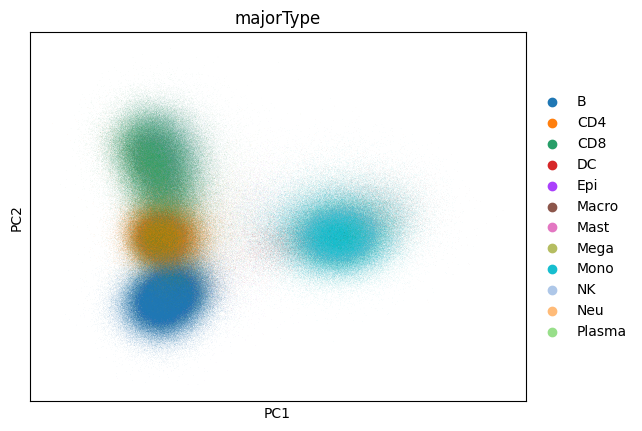

In [15]:
sc.pl.pca(adata, color="majorType")

Further support for `dask` is a work in progress. However, many operations past this point can work with the dimensionality reduction directly in memory. With scanpy `1.10` many of these operations can be accelerated to make working with large datasets significantly easier. For example:

* Using alternative KNN backends for faster neighbor calculation {doc}`/how-to/knn-transformers`
* Using the `igraph` backend for clustering

In [16]:
%%time
from sklearn_ann.kneighbors.annoy import AnnoyTransformer  # noqa: E402

transformer = AnnoyTransformer(n_neighbors=15)
sc.pp.neighbors(adata, transformer=transformer)

CPU times: user 1min 46s, sys: 1.56 s, total: 1min 48s
Wall time: 1min 25s


In [17]:
%%time
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

CPU times: user 2min 49s, sys: 5.25 s, total: 2min 55s
Wall time: 2min 54s


UMAP computation can be slow however, so we have it commented out and show the plotting result (although if you wish to run with your own data, you will need to uncomment):

In [20]:
# %%time
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=["leiden", "majorType"])